# 9- Importation des bibliothèque

In [36]:
import random
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.manifold import TSNE

# 2- Génération de notre dataset de signaux

Afin de générer notre dataset de signaux, nous allons utiliser un modèle. Le modèle sera un modèle classique trend+periodic. C'est à dire un polynome d'ordre n + une somme de cosinus avec des fréquences et des phases différentes. Nos signaux seront ainsi défini uniquement par leur paramètre. Enfin nous ajoutons du bruit.

In [37]:
class SignalGenerator:

    def __init__(self):
        self.time = None

    def _sort_params(self, a, b, w):
        """
        Trie les fréquences et leurs amplitudes associées.

        Args:
            a (list): Coefficients du polynôme.
            b (list): Amplitudes des cosinus.
            w (list): Fréquences des cosinus.

        Returns:
            tuple: Coefficients triés, amplitudes triées et fréquences triées.
        """
        sorted_indices = np.argsort(w)  # Indices pour trier les fréquences
        sorted_w = [w[i] for i in sorted_indices]
        sorted_b = [b[i] for i in sorted_indices]
        return a, sorted_b, sorted_w

    def generate_signal(self, a, b, w,phi, num_samples=10000, time_range=(-1, 1), noise_std=0.1):
        """
        Génère un signal basé sur les paramètres donnés.

        Args:
            a (list): Coefficients du polynôme (a0, a1, a2, a3).
            b (list): Amplitudes des cosinus.
            w (list): Fréquences des cosinus.
            phi (list): Phases des cosinus.
            num_samples (int): Nombre d'échantillons temporels par signal.
            time_range (tuple): Intervalle de temps (début, fin).
            noise_std (float): Écart-type du bruit ajouté.

        Returns:
            np.ndarray: Signal généré.
        """
        self.time = np.linspace(time_range[0], time_range[1], num_samples)
        #a, b, w = self._sort_params(a, b, w)
        poly_part = sum(a[i] * (self.time ** i) for i in range(len(a)))
        cosine_part = sum(b[i] * np.cos(w[i] * self.time+ phi[i]) for i in range(len(w)))
        noise = np.random.normal(0, noise_std, size=num_samples)
        signal = poly_part + cosine_part + noise

        return signal

    def generate_dataset(self, num_signals, a_range=(0, 10), b_range=(0, 10), w_range=(0.1, 10), phi_range = (0, 2*np.pi), num_samples=10000, time_range=(0, 10), noise_std=0.5):
        """
        Génère un dataset de signaux avec des paramètres aléatoires.

        Args:
            num_signals (int): Nombre de signaux à générer.
            a_range (tuple): Intervalle pour les coefficients du polynôme.
            b_range (tuple): Intervalle pour les amplitudes des cosinus.
            w_range (tuple): Intervalle pour les fréquences.
            num_samples (int): Nombre d'échantillons temporels par signal.
            time_range (tuple): Intervalle de temps (début, fin).
            noise_std (float): Écart-type du bruit ajouté.

        Returns:
            list: Liste de tuples (signal, paramètres).
        """
        dataset = []
        nb_poly = 4
        nb_cos = 3
        for _ in tqdm(range(num_signals), desc='generating signals'):
            # on génère les coefficients du polynome
            a = [np.random.uniform(a_range[0], a_range[1]) for _ in range(nb_poly)]
            # on génère les amplitudes
            b = [np.random.uniform(b_range[0], b_range[1]) for _ in range(nb_cos)]
            # on génére les pulsation
            w = [np.random.uniform(w_range[0], w_range[1]) for _ in range(nb_cos)]
            #on trie la liste des fréquences
            w.sort()
            #on génère des phases aléatoires
            phi = [np.random.uniform(phi_range[0], phi_range[1]) for _ in range(nb_cos)]

            signal = self.generate_signal(a, b, w,phi, num_samples=num_samples, time_range=time_range, noise_std=noise_std)

            dataset.append((signal, {"a": a, "b": b, "w": w, "phi": phi}))

        return dataset

generating signals: 100%|██████████| 20/20 [00:00<00:00, 2383.60it/s]


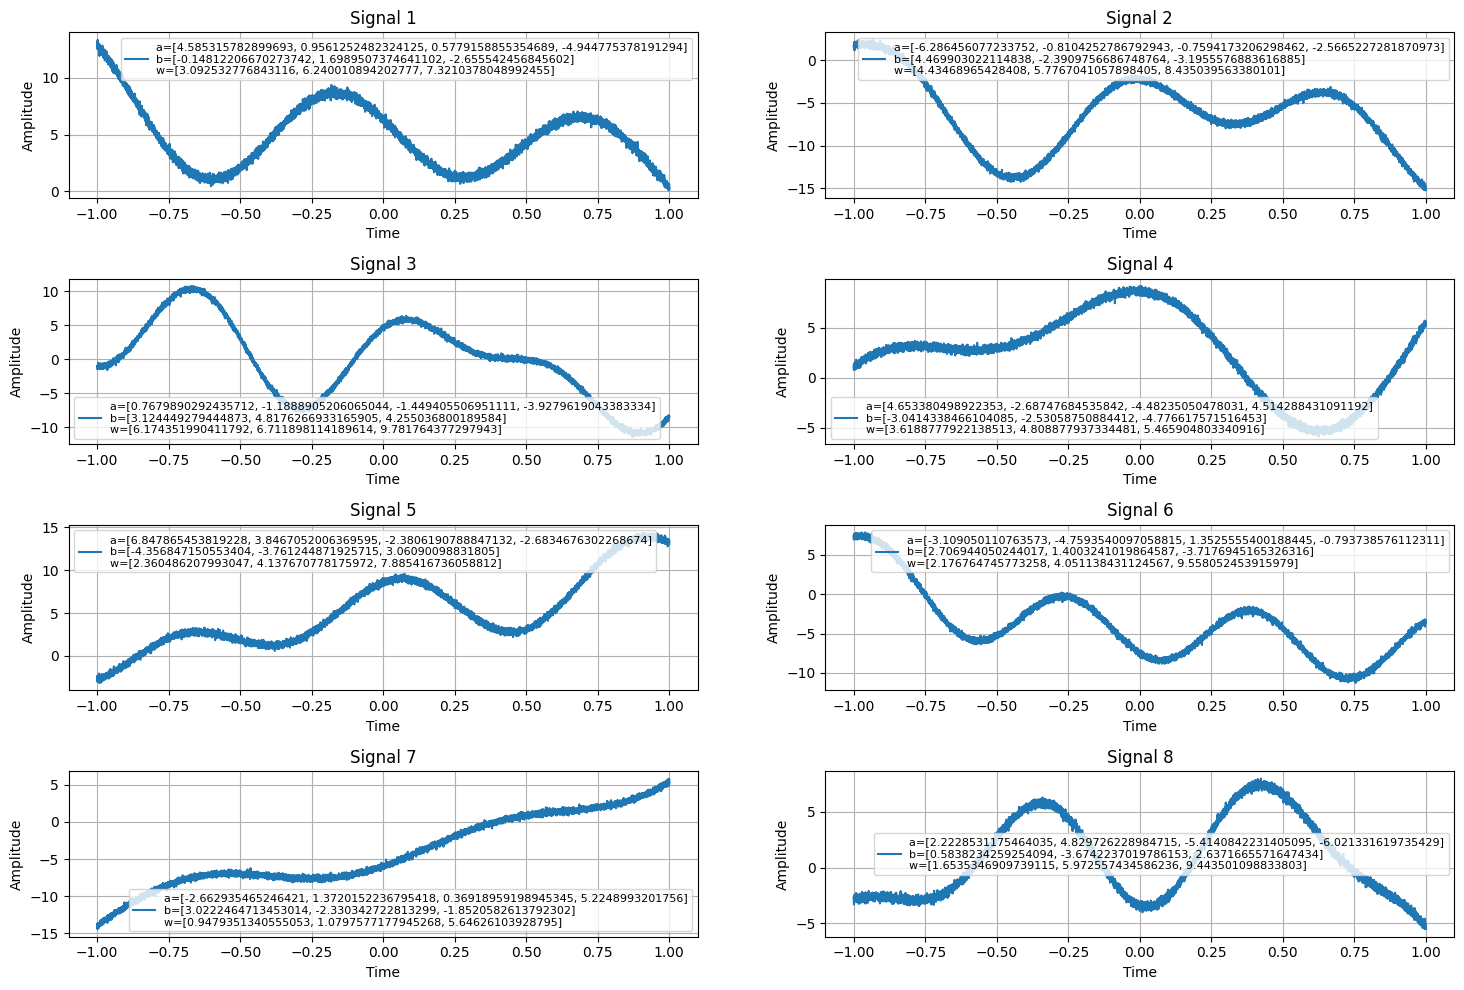

In [38]:
generator = SignalGenerator()

dataset = generator.generate_dataset(num_signals=20, a_range=(-7, 7), b_range=(-5, 5), w_range=(0.5, 10), phi_range = (0, 2*np.pi), num_samples=10000, time_range=(-1, 1), noise_std=0.2)

random_indices = random.sample(range(len(dataset)), 8)
selected_signals = [dataset[i] for i in random_indices]

plt.figure(figsize=(15, 10))
for i, (signal, params) in enumerate(selected_signals):
    plt.subplot(4, 2, i + 1)  # Grille de 4x2
    plt.plot(generator.time, signal, label=f"a={params['a']}\nb={params['b']}\nw={params['w']}")
    plt.title(f"Signal {i + 1}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(fontsize=8)
    plt.grid(True)

plt.tight_layout()
plt.show()

# 2- Création de l'AE

### Architecture d'un Auto-Encodeur (AE)

Un Auto-Encodeur (AE) est un type de réseau de neurones utilisé pour apprendre une représentation compacte (encodage) des données d'entrée. Il se compose de deux parties principales :

1. **Encodeur** : Cette partie du réseau prend les données d'entrée et les compresse en une représentation de dimension inférieure, appelée espace latent.
2. **Décodeur** : Cette partie prend la représentation latente et tente de reconstruire les données d'origine.

### Fonction de Perte (Loss Function)

La fonction de perte d'un AE est généralement conçue pour minimiser la différence entre les données d'entrée et les données reconstruites. Une fonction de perte courante est l'erreur quadratique moyenne (MSE) :


$\text{Loss} = \frac{1}{n} \sum_{i=1}^{n} (x_i - \hat{x}_i)^2$


où $ x_i $ est l'entrée originale et $ \hat{x}_i $ est la reconstruction.


## Maintien des Distances dans l'Espace Latent

Pour maintenir les distances dans l'espace latent, on ajoute un terme de régularisation à la fonction de perte. Ce terme de régularisation compare les distances entre les points dans l'espace des paramètres (\(\theta\)) et les distances correspondantes dans l'espace latent (\(z\)) :

$$
\text{distance\_loss} = \frac{1}{n} \sum_{i=1}^{n} \left( \|\theta_i - \theta_j\|_2 - \|z_i - z_j\|_2 \right)^2
$$

où \( \|x - y\|_2 \) représente la norme euclidienne (distance de Minkowski de degré 2) entre deux points \( x \) et \( y \).

Ce terme de régularisation, appelé `distance_loss`, aide à maintenir une structure dans l'espace latent en forçant les distances entre les points dans l'espace latent à correspondre aux distances entre les points dans l'espace des paramètres. Cela permet de mieux capturer les relations entre les points de données.


In [39]:
import torch
import torch.nn as nn
import torch.optim as optim

class SignalAutoEncoder(nn.Module):
    def __init__(self, input_dim, latent_dim, learning_rate=0.001):
        """
        Initialise l'autoencodeur pour les signaux et les outils d'entraînement.

        Args:
            input_dim (int): Dimension des signaux d'entrée (nombre d'échantillons temporels).
            latent_dim (int): Dimension de l'espace latent.
            learning_rate (float): Taux d'apprentissage.
        """
        super(SignalAutoEncoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, latent_dim)
        )
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 128),
            nn.ReLU(),
            nn.Linear(128, input_dim)
        )
        
        self.optimizer = optim.Adam(self.parameters(), lr=learning_rate)

    def forward(self, x):
        """
        Passe avant de l'autoencodeur.

        Args:
            x (torch.Tensor): Signal d'entrée.

        Returns:
            torch.Tensor: Signal reconstruit.
            torch.Tensor: Représentation latente.
        """
        z = self.encoder(x)
        x_reconstructed = self.decoder(z)
        return x_reconstructed, z

class SignalAETrainer:
    def __init__(self, autoencoder, learning_rate=0.001):
        """
        Initialise l'entraîneur pour l'autoencodeur.

        Args:
            autoencoder (SignalAutoEncoder): Instance de l'autoencodeur.
            learning_rate (float): Taux d'apprentissage.
        """
        self.autoencoder = autoencoder
        self.optimizer = optim.Adam(autoencoder.parameters(), lr=learning_rate)

    def train(self, train_loader, val_loader, params_train, params_val, epochs=20, alpha=1.0, beta=1.0):
        """
        Entraîne l'autoencodeur avec une phase de validation.

        Args:
            train_loader (DataLoader): DataLoader pour les données d'entraînement.
            val_loader (DataLoader): DataLoader pour les données de validation.
            params_train (torch.Tensor): Paramètres associés aux signaux d'entraînement.
            params_val (torch.Tensor): Paramètres associés aux signaux de validation.
            epochs (int): Nombre d'époques d'entraînement.
            alpha (float): Poids pour la perte de reconstruction.
            beta (float): Poids pour la perte de distance.

        Returns:
            tuple: Historique des pertes d'entraînement et de validation.
        """
        train_losses = []
        val_losses = []

        for epoch in tqdm(range(epochs), desc='epochs'):
            # Phase d'entraînement
            self.autoencoder.train()
            train_loss = 0.0
            for signals, indices in train_loader:
                self.optimizer.zero_grad()
                reconst, latent = self.autoencoder(signals)
                loss = compute_loss(signals, reconst, latent, params_train[indices], alpha, beta)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()
            train_loss /= len(train_loader)
            train_losses.append(train_loss)

            # Phase de validation
            self.autoencoder.eval()
            val_loss = 0.0
            with torch.no_grad():
                for signals, indices in val_loader:
                    reconst, latent = self.autoencoder(signals)
                    loss = compute_loss(signals, reconst, latent, params_val[indices], alpha, beta)
                    val_loss += loss.item()
            val_loss /= len(val_loader)
            val_losses.append(val_loss)

            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

        return train_losses, val_losses
    

def compute_loss(x, x_reconstructed, z, params, alpha=1.0, beta=1.0):
    """
    Calcule la perte pour l'entraînement de l'autoencodeur.

    Args:
        x (torch.Tensor): Signaux originaux.
        x_reconstructed (torch.Tensor): Signaux reconstruits.
        z (torch.Tensor): Représentation latente des signaux.
        params (torch.Tensor): Paramètres des signaux originaux (a et w).
        alpha (float): Poids pour la perte de reconstruction.
        beta (float): Poids pour la perte de distance.

    Returns:
        torch.Tensor: Perte totale.
    """
    # Perte de reconstruction (MSE)
    reconstruction_loss = nn.MSELoss()(x_reconstructed, x)

    # Perte de distance (respect des distances entre paramètres)
    pairwise_dist_params = torch.cdist(params, params, p=2)
    pairwise_dist_latent = torch.cdist(z, z, p=2)
    distance_loss = torch.mean((pairwise_dist_params - pairwise_dist_latent) ** 2)

    # Perte totale
    total_loss = alpha * reconstruction_loss + beta * distance_loss
    return total_loss

def plot_losses(train_losses, val_losses=None):
    """
    Affiche l'évolution des pertes d'entraînement et de validation.

    Args:
        train_losses (list): Liste des pertes d'entraînement.
        val_losses (list): Liste des pertes de validation (optionnel).
    """
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Train Loss', color='blue')
    if val_losses is not None:
        plt.plot(range(1, len(val_losses) + 1), val_losses, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Evolution des pertes')
    plt.legend()
    plt.grid(True)
    plt.show()

# 3- Entrainement de l'AE

epochs:   3%|▎         | 1/30 [00:05<02:49,  5.85s/it]

Epoch 1/30, Train Loss: 39.4540, Val Loss: 16.8256


epochs:   7%|▋         | 2/30 [00:10<02:31,  5.43s/it]

Epoch 2/30, Train Loss: 14.5889, Val Loss: 12.4758


epochs:  10%|█         | 3/30 [00:15<02:21,  5.23s/it]

Epoch 3/30, Train Loss: 12.4229, Val Loss: 12.9324


epochs:  13%|█▎        | 4/30 [00:20<02:12,  5.11s/it]

Epoch 4/30, Train Loss: 11.7013, Val Loss: 11.8054


epochs:  17%|█▋        | 5/30 [00:25<02:05,  5.01s/it]

Epoch 5/30, Train Loss: 11.3547, Val Loss: 11.1095


epochs:  20%|██        | 6/30 [00:30<02:00,  5.00s/it]

Epoch 6/30, Train Loss: 11.1224, Val Loss: 10.8147


epochs:  23%|██▎       | 7/30 [00:35<01:54,  4.96s/it]

Epoch 7/30, Train Loss: 10.6700, Val Loss: 10.7051


epochs:  27%|██▋       | 8/30 [00:40<01:50,  5.01s/it]

Epoch 8/30, Train Loss: 10.8507, Val Loss: 10.7944


epochs:  30%|███       | 9/30 [00:45<01:45,  5.02s/it]

Epoch 9/30, Train Loss: 10.6247, Val Loss: 10.4381


epochs:  33%|███▎      | 10/30 [00:51<01:42,  5.15s/it]

Epoch 10/30, Train Loss: 10.5460, Val Loss: 10.5158


epochs:  37%|███▋      | 11/30 [00:56<01:39,  5.23s/it]

Epoch 11/30, Train Loss: 10.4250, Val Loss: 11.0938


epochs:  40%|████      | 12/30 [01:06<02:00,  6.71s/it]

Epoch 12/30, Train Loss: 10.5615, Val Loss: 10.8304


epochs:  43%|████▎     | 13/30 [01:16<02:08,  7.57s/it]

Epoch 13/30, Train Loss: 10.3973, Val Loss: 10.3597


epochs:  47%|████▋     | 14/30 [01:25<02:10,  8.15s/it]

Epoch 14/30, Train Loss: 10.5699, Val Loss: 11.2956


epochs:  50%|█████     | 15/30 [01:35<02:08,  8.54s/it]

Epoch 15/30, Train Loss: 10.2258, Val Loss: 10.0770


epochs:  53%|█████▎    | 16/30 [01:44<02:03,  8.83s/it]

Epoch 16/30, Train Loss: 11.6030, Val Loss: 14.1610


epochs:  57%|█████▋    | 17/30 [01:54<02:00,  9.26s/it]

Epoch 17/30, Train Loss: 11.2748, Val Loss: 11.5555


epochs:  60%|██████    | 18/30 [02:05<01:54,  9.51s/it]

Epoch 18/30, Train Loss: 10.2746, Val Loss: 10.2548


epochs:  63%|██████▎   | 19/30 [02:15<01:47,  9.77s/it]

Epoch 19/30, Train Loss: 10.2377, Val Loss: 10.9798


epochs:  67%|██████▋   | 20/30 [02:26<01:40, 10.07s/it]

Epoch 20/30, Train Loss: 10.1628, Val Loss: 10.2614


epochs:  70%|███████   | 21/30 [02:36<01:32, 10.24s/it]

Epoch 21/30, Train Loss: 10.0647, Val Loss: 10.1764


epochs:  73%|███████▎  | 22/30 [02:46<01:21, 10.15s/it]

Epoch 22/30, Train Loss: 10.3669, Val Loss: 9.9205


epochs:  77%|███████▋  | 23/30 [02:57<01:11, 10.21s/it]

Epoch 23/30, Train Loss: 10.2495, Val Loss: 10.4139


epochs:  80%|████████  | 24/30 [03:06<01:00, 10.11s/it]

Epoch 24/30, Train Loss: 10.0937, Val Loss: 9.5485


epochs:  83%|████████▎ | 25/30 [03:14<00:47,  9.45s/it]

Epoch 25/30, Train Loss: 9.9682, Val Loss: 9.9135


epochs:  87%|████████▋ | 26/30 [03:20<00:33,  8.27s/it]

Epoch 26/30, Train Loss: 10.1620, Val Loss: 9.8977


epochs:  90%|█████████ | 27/30 [03:28<00:24,  8.07s/it]

Epoch 27/30, Train Loss: 9.8873, Val Loss: 10.4131


epochs:  93%|█████████▎| 28/30 [03:38<00:17,  8.76s/it]

Epoch 28/30, Train Loss: 9.9857, Val Loss: 9.9608


epochs:  97%|█████████▋| 29/30 [03:48<00:09,  9.15s/it]

Epoch 29/30, Train Loss: 10.1401, Val Loss: 10.1934


epochs: 100%|██████████| 30/30 [03:58<00:00,  7.95s/it]

Epoch 30/30, Train Loss: 12.5197, Val Loss: 10.1250


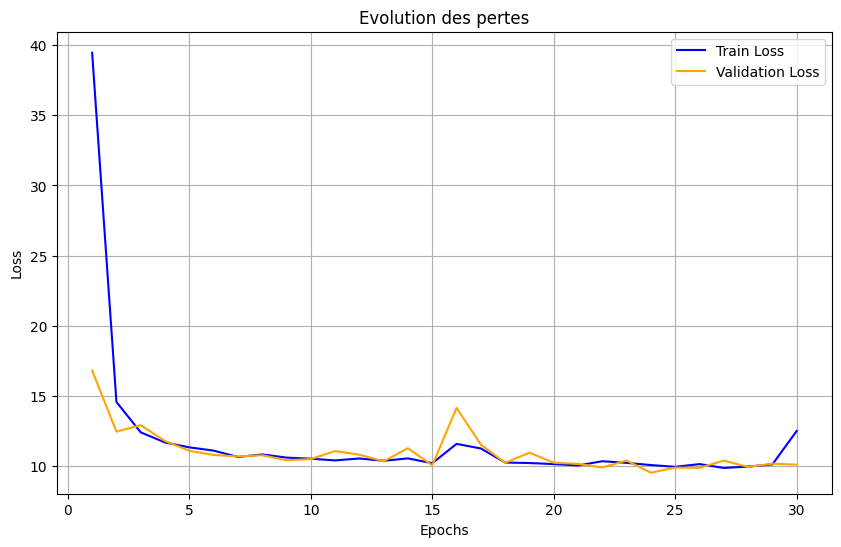

In [26]:
full_dataset = generator.generate_dataset(num_signals=20000, a_range=(-7, 7), b_range=(-5, 5), w_range=(0.5, 10), num_samples=10000, time_range=(-1, 1), noise_std=0.2)

train_dataset = full_dataset[:16000]  # 80% train
val_dataset = full_dataset[16000:]   # 20% validation

train_signals = np.array([item[0] for item in train_dataset])
train_params = np.array([[*item[1]["a"], *item[1]["w"]] for item in train_dataset])
train_signals_tensor = torch.tensor(train_signals, dtype=torch.float32)
train_params_tensor = torch.tensor(train_params, dtype=torch.float32)

val_signals = np.array([item[0] for item in val_dataset])
val_params = np.array([[*item[1]["a"], *item[1]["w"]] for item in val_dataset])
val_signals_tensor = torch.tensor(val_signals, dtype=torch.float32)
val_params_tensor = torch.tensor(val_params, dtype=torch.float32)

train_indices = torch.arange(len(train_signals_tensor))
train_tensor_dataset = TensorDataset(train_signals_tensor, train_indices)
train_dataloader = DataLoader(train_tensor_dataset, batch_size=32, shuffle=True)

val_indices = torch.arange(len(val_signals_tensor))
val_tensor_dataset = TensorDataset(val_signals_tensor, val_indices)
val_dataloader = DataLoader(val_tensor_dataset, batch_size=32, shuffle=False)

input_dim = train_signals.shape[1]
latent_dim = 14
autoencoder = SignalAutoEncoder(input_dim, latent_dim)

trainer = SignalAETrainer(autoencoder)

train_losses, val_losses = trainer.train(
    train_dataloader, val_dataloader, train_params_tensor, val_params_tensor, epochs=30, alpha=1.0, beta=1.0
)

plot_losses(train_losses, val_losses)

# 4- Etude de l'espace latent

## 4.1 Verification de la proximité sur un exemple de signaux 

Distance dans l'espace latent (signaux éloignés) : 13.9327
Distance dans l'espace latent (signaux proches) : 0.9611
Distance dans l'espace des paramètres (signaux éloignés) : 23.5606
Distance dans l'espace des paramètres (signaux proches) : 0.8353


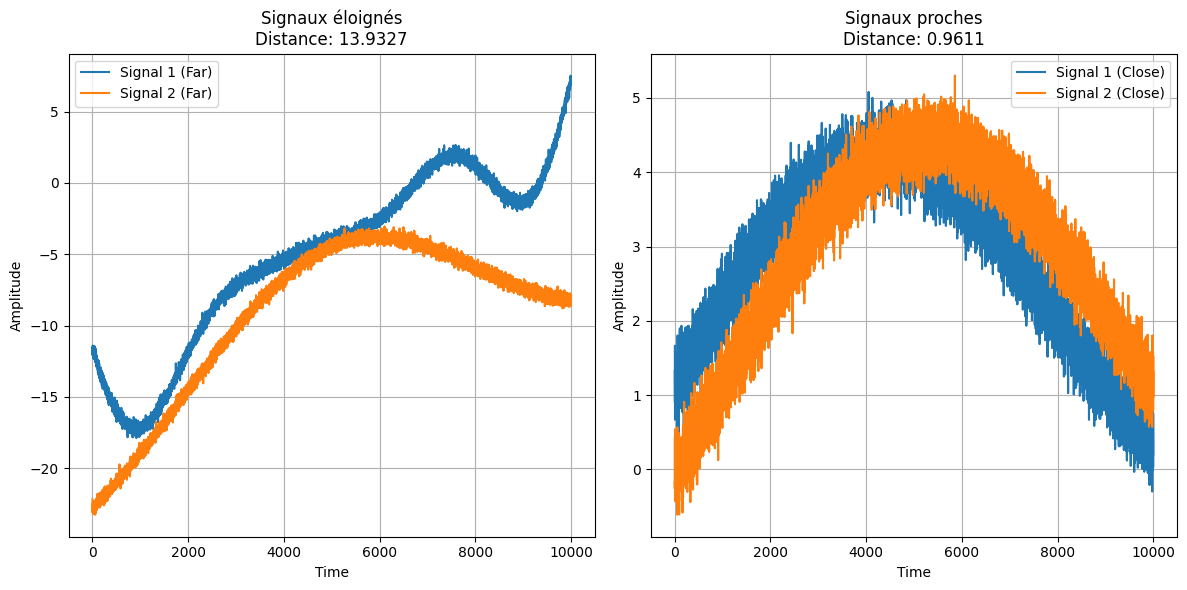

In [54]:
# Fonction pour trier les listes de paramètres selon les valeurs de w
def sort_params(params):
    order = sorted(range(len(params["w"])), key=lambda i: params["w"][i])
    return {
        key: np.array([params[key][i] for i in order]) for key in params
    }

# Trier les paramètres avant de générer les signaux
params1_far = sort_params({"a": [10, -5, 3, 0.1], "b": [4, 3, 2], "w": [8, 5, 10], "phi": [3, 0, 0]})
params2_far = sort_params({"a": [-10, 8, -2, 0.5], "b": [1, 2, 3], "w": [1, 2, 3], "phi": [1, 0, 0]})

params1_close = sort_params({"a": [1, 0.5, -0.1, 0.05], "b": [2, 1.5, 1], "w": [2, 1.5, 1.1], "phi": [0.5, 0, 0]})
params2_close = sort_params({"a": [1, 0.6, -0.15, 0.05], "b": [2.1, 1.4, 1.05], "w": [2.05, 1.45, 1.08], "phi": [0, 0, 0]})

# Générer les signaux avec les paramètres triés
signal1_far = generator.generate_signal(
    a=params1_far["a"], b=params1_far["b"], w=params1_far["w"], phi=params1_far["phi"], noise_std=0.25
)
signal2_far = generator.generate_signal(
    a=params2_far["a"], b=params2_far["b"], w=params2_far["w"], phi=params2_far["phi"], noise_std=0.25
)

signal1_close = generator.generate_signal(
    a=params1_close["a"], b=params1_close["b"], w=params1_close["w"], phi=params1_close["phi"], noise_std=0.25
)
signal2_close = generator.generate_signal(
    a=params2_close["a"], b=params2_close["b"], w=params2_close["w"], phi=params2_close["phi"], noise_std=0.25
)

# Convertir les signaux en tenseurs
test_signals = torch.tensor(
    [signal1_far, signal2_far, signal1_close, signal2_close], dtype=torch.float32
)

# Passer les signaux dans l'autoencodeur pour obtenir les représentations latentes
autoencoder.eval()
with torch.no_grad():
    _, test_latent = autoencoder(test_signals)

# Calculer les distances dans l'espace latent
distance_far = torch.norm(test_latent[0] - test_latent[1], p=2).item()
distance_close = torch.norm(test_latent[2] - test_latent[3], p=2).item()

# Calculer les distances dans l'espace des paramètres
distance_params_far = 0 
distance_params_close = 0
for key in params1_far : 
    distance_params_far += np.sqrt((np.abs(params1_far[key] - params2_far[key])**2).sum())
    distance_params_close += np.sqrt((np.abs(params1_close[key] - params2_close[key])**2).sum())

# Afficher les distances
print(f"Distance dans l'espace latent (signaux éloignés) : {distance_far:.4f}")
print(f"Distance dans l'espace latent (signaux proches) : {distance_close:.4f}")
print(f"Distance dans l'espace des paramètres (signaux éloignés) : {distance_params_far:.4f}")
print(f"Distance dans l'espace des paramètres (signaux proches) : {distance_params_close:.4f}")

# Visualisation
plt.figure(figsize=(12, 6))

# Signaux éloignés
plt.subplot(1, 2, 1)
plt.plot(signal1_far, label="Signal 1 (Far)")
plt.plot(signal2_far, label="Signal 2 (Far)")
plt.title(f"Signaux éloignés\nDistance: {distance_far:.4f}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

# Signaux proches
plt.subplot(1, 2, 2)
plt.plot(signal1_close, label="Signal 1 (Close)")
plt.plot(signal2_close, label="Signal 2 (Close)")
plt.title(f"Signaux proches\nDistance: {distance_close:.4f}")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

## 4.2 Etude t-sne de deux clusters de signaux 

generating signals: 100%|██████████| 200/200 [00:00<00:00, 1244.26it/s]


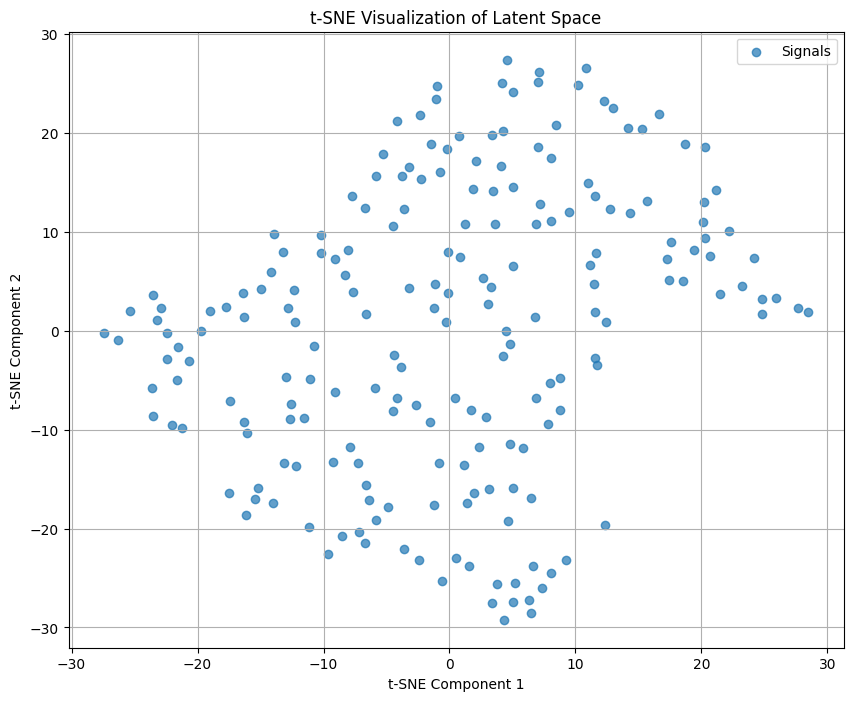

In [28]:
dataset_tsne = generator.generate_dataset(
    num_signals=200, a_range=(-7, 7), b_range=(-5, 5), w_range=(0.5, 10), num_samples=10000, time_range=(-1, 1), noise_std=0.2
)

latent_vectors = []
for signal, _ in dataset_tsne:
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        _, latent = autoencoder(signal_tensor)  
    latent_vectors.append(latent.squeeze().numpy()) 

latent_vectors = np.array(latent_vectors)

tsne = TSNE(n_components=2, perplexity=13, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[:, 0], latent_2d[:, 1], alpha=0.7, label="Signals")
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.legend()
plt.grid(True)
plt.show()



generating signals: 100%|██████████| 200/200 [00:00<00:00, 1052.14it/s]


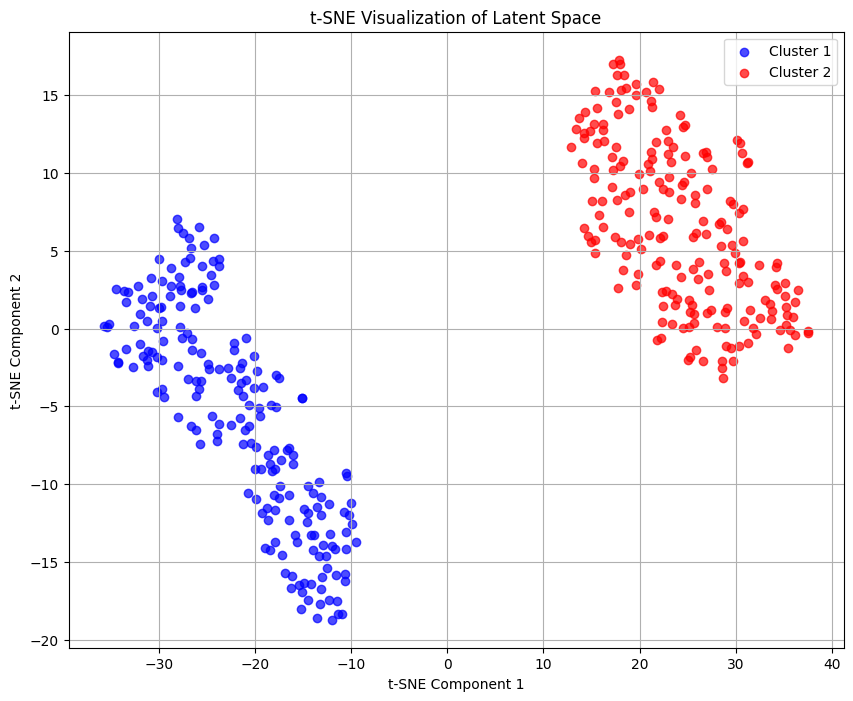

In [86]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)


dataset_cluster_1 = generator.generate_dataset(
    num_signals=200, a_range=(0, 2), b_range=(0, 2), w_range=(0.5, 2),phi_range=(0, np.pi), num_samples=10000, time_range=(-1, 1), noise_std=0.2
)

dataset_cluster_2 = generator.generate_dataset(
    num_signals=200, a_range=(5, 7), b_range=(4, 6), w_range=(8, 10),phi_range = (np.pi, 2*np.pi), num_samples=10000, time_range=(-1, 1), noise_std=0.2
)


signals_cluster_1 = np.array([item[0] for item in dataset_cluster_1])
signals_cluster_2 = np.array([item[0] for item in dataset_cluster_2])

signals_cluster_1_tensor = torch.tensor(signals_cluster_1, dtype=torch.float32).to(device)
signals_cluster_2_tensor = torch.tensor(signals_cluster_2, dtype=torch.float32).to(device)

autoencoder.eval()
latent_vectors_cluster_1 = []
latent_vectors_cluster_2 = []

with torch.no_grad():
    for signal in signals_cluster_1_tensor:
        _, latent = autoencoder(signal.unsqueeze(0).to(device))
        latent_vectors_cluster_1.append(latent.squeeze().cpu().numpy())

    for signal in signals_cluster_2_tensor:
        _, latent = autoencoder(signal.unsqueeze(0).to(device))
        latent_vectors_cluster_2.append(latent.squeeze().cpu().numpy())

latent_vectors_cluster_1 = np.array(latent_vectors_cluster_1)
latent_vectors_cluster_2 = np.array(latent_vectors_cluster_2)

all_latent_vectors = np.vstack([latent_vectors_cluster_1, latent_vectors_cluster_2])
labels = np.array([0] * len(latent_vectors_cluster_1) + [1] * len(latent_vectors_cluster_2))

tsne = TSNE(n_components=2, random_state=42)
latent_2d = tsne.fit_transform(all_latent_vectors)

plt.figure(figsize=(10, 8))
plt.scatter(latent_2d[labels == 0, 0], latent_2d[labels == 0, 1], c='blue', label='Cluster 1', alpha=0.7)
plt.scatter(latent_2d[labels == 1, 0], latent_2d[labels == 1, 1], c='red', label='Cluster 2', alpha=0.7)
plt.title('t-SNE Visualization of Latent Space')
plt.xlabel('t-SNE Component 1')
plt.ylabel('t-SNE Component 2')
plt.legend()
plt.grid(True)
plt.show()


generating signals: 100%|██████████| 4/4 [00:00<00:00, 697.66it/s]


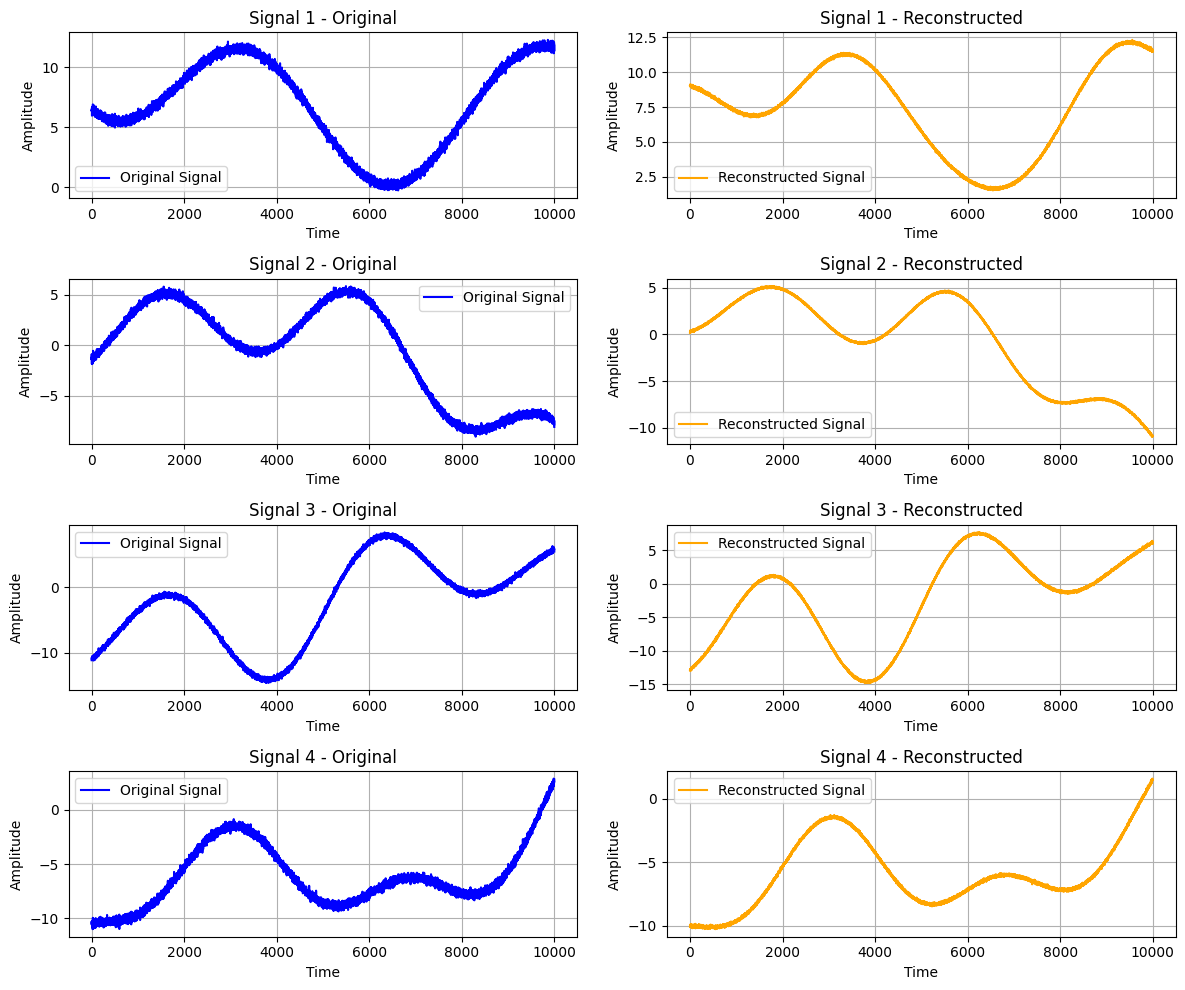

In [30]:
random_signals = generator.generate_dataset(
    num_signals=4, a_range=(-7, 7), b_range=(-5, 5), w_range=(0.5, 10), num_samples=10000, time_range=(-1, 1), noise_std=0.2
    )

original_signals = np.array([item[0] for item in random_signals])

test_signals = torch.tensor(original_signals, dtype=torch.float32)

autoencoder.eval()
with torch.no_grad():
    reconstructed_signals, _ = autoencoder(test_signals)

reconstructed_signals = reconstructed_signals.numpy()

plt.figure(figsize=(12, 10))

for i in range(4):

    plt.subplot(4, 2, 2 * i + 1)
    plt.plot(original_signals[i], label="Original Signal", color="blue")
    plt.title(f"Signal {i + 1} - Original")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

    plt.subplot(4, 2, 2 * i + 2)
    plt.plot(reconstructed_signals[i], label="Reconstructed Signal", color="orange")
    plt.title(f"Signal {i + 1} - Reconstructed")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

## 4.3-Etude de différente trajectoire de paramètres dans l'espace latent

Dans cette partie nous allons voir comment dans l'espace latent notre signal se déplace si nous faisons varier qu'un seul paramètre avec les autres fixé. 

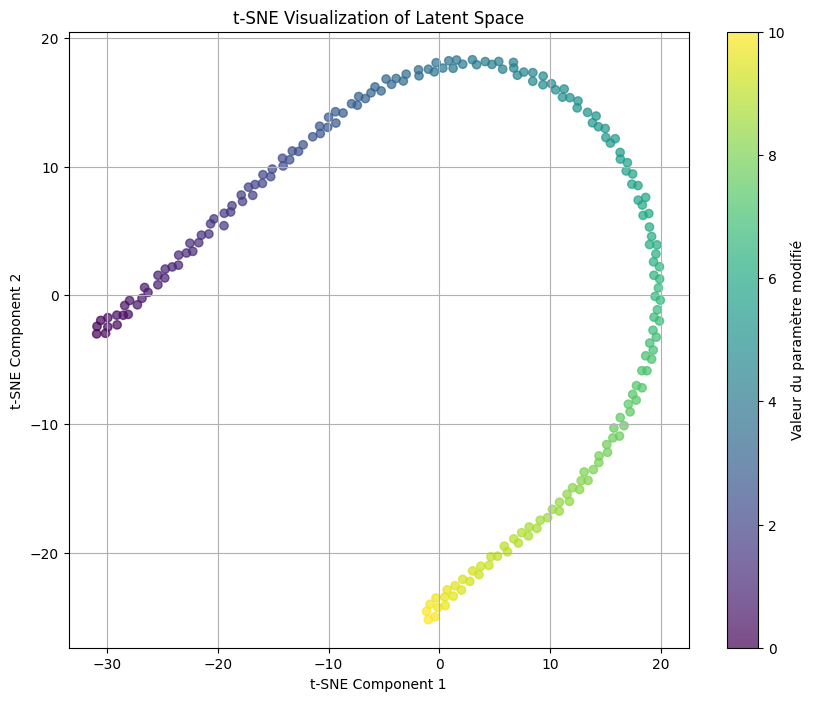

In [70]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE

# Fonction pour générer une suite de signaux avec un paramètre qui augmente progressivement
def generate_signal_sequence(generator, param_name,index_param,  initial_params, start, stop, num_steps, **kwargs):
    """
    Génère une séquence de signaux en faisant varier un seul paramètre.

    Args:
        generator (object): Objet contenant la méthode generate_signal.
        param_name (str): Nom du paramètre à faire varier ("a", "b", "w", "phi").
        initial_params (dict): Dictionnaire des paramètres initiaux.
        start (float): Valeur initiale du paramètre à faire varier.
        stop (float): Valeur finale du paramètre à faire varier.
        num_steps (int): Nombre d'étapes entre start et stop.
        **kwargs: Arguments supplémentaires pour la méthode generate_signal.

    Returns:
        list: Liste des signaux générés.
        list: Liste des valeurs du paramètre modifié.
    """
    signals = []
    modified_values = np.linspace(start, stop, num_steps)

    for value in modified_values:
        params = initial_params.copy()
        params[param_name] = [value if i == index_param else v for i, v in enumerate(params[param_name])]
        signal = generator.generate_signal(
            a=params["a"], b=params["b"], w=params["w"], phi=params["phi"], **kwargs
        )
        signals.append(signal)

    return signals, modified_values

# Initialisation des paramètres initiaux
initial_params = {
    "a": [1, 0.5, -0.1, 0.05],
    "b": [2, 1.5, 1],
    "w": [2, 1.5, 1.1],
    "phi": [0, 0, 0],
}

# Générer un dataset complet pour t-SNE
signals, modified_values = generate_signal_sequence(
    generator=generator,
    param_name="a",
    index_param=2,
    initial_params=initial_params,
    start=0,
    stop=10,
    num_steps=200,
    num_samples=10000,
    time_range=(-1, 1),
    noise_std=0.2
)

# Obtenir les représentations latentes des signaux
latent_vectors = []
for signal in signals:
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        _, latent = autoencoder(signal_tensor)  
    latent_vectors.append(latent.squeeze().numpy())

latent_vectors = np.array(latent_vectors)

# Appliquer t-SNE sur les vecteurs latents
tsne = TSNE(n_components=2, perplexity=13, random_state=42)
latent_2d = tsne.fit_transform(latent_vectors)

# Visualisation des positions t-SNE
plt.figure(figsize=(10, 8))
sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=modified_values, cmap="viridis", alpha=0.7, label="Signals")
plt.title("t-SNE Visualization of Latent Space")
plt.xlabel("t-SNE Component 1")
plt.ylabel("t-SNE Component 2")
plt.colorbar(sc, label="Valeur du paramètre modifié")
plt.grid(True)
plt.show()


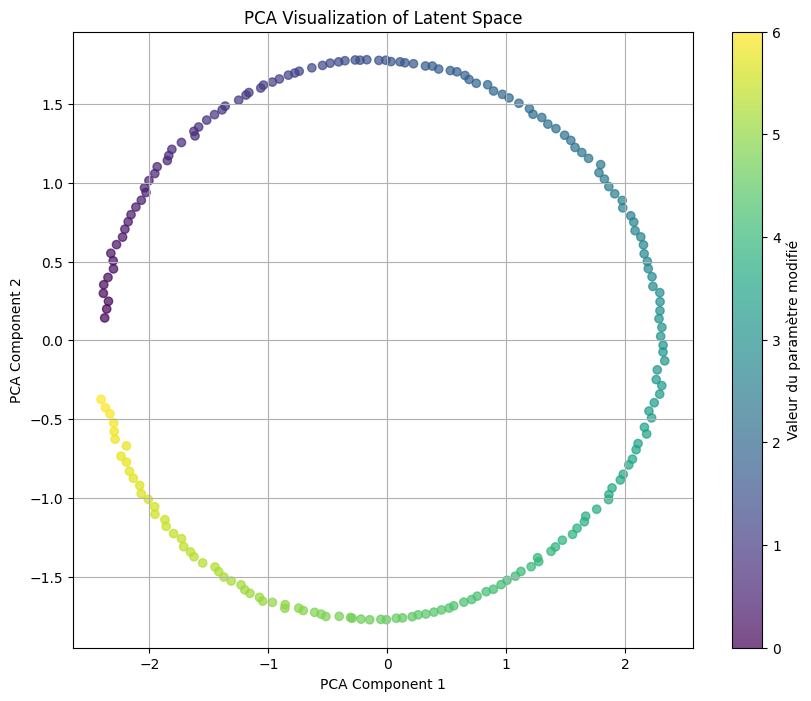

In [85]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Fonction pour générer une suite de signaux avec un paramètre qui augmente progressivement
def generate_signal_sequence(generator, param_name,index_param,  initial_params, start, stop, num_steps, **kwargs):
    """
    Génère une séquence de signaux en faisant varier un seul paramètre.

    Args:
        generator (object): Objet contenant la méthode generate_signal.
        param_name (str): Nom du paramètre à faire varier ("a", "b", "w", "phi").
        initial_params (dict): Dictionnaire des paramètres initiaux.
        start (float): Valeur initiale du paramètre à faire varier.
        stop (float): Valeur finale du paramètre à faire varier.
        num_steps (int): Nombre d'étapes entre start et stop.
        **kwargs: Arguments supplémentaires pour la méthode generate_signal.

    Returns:
        list: Liste des signaux générés.
        list: Liste des valeurs du paramètre modifié.
    """
    signals = []
    modified_values = np.linspace(start, stop, num_steps)

    for value in modified_values:
        params = initial_params.copy()
        params[param_name] = [value if i == index_param else v for i, v in enumerate(params[param_name])]
        signal = generator.generate_signal(
            a=params["a"], b=params["b"], w=params["w"], phi=params["phi"], **kwargs
        )
        signals.append(signal)

    return signals, modified_values

# Initialisation des paramètres initiaux
initial_params = {
    "a": [1, 0.5, -0.1, 0.05],
    "b": [2, 1.5, 1],
    "w": [2, 1.5, 1.1],
    "phi": [0, 0, 0],
}

# Générer un dataset complet pour t-SNE
signals, modified_values = generate_signal_sequence(
    generator=generator,
    param_name="phi",
    index_param=0,
    initial_params=initial_params,
    start=0,
    stop=6,
    num_steps=200,
    num_samples=10000,
    time_range=(-1, 1),
    noise_std=0.2
)

# Obtenir les représentations latentes des signaux
latent_vectors = []
for signal in signals:
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        _, latent = autoencoder(signal_tensor)  
    latent_vectors.append(latent.squeeze().numpy())

latent_vectors = np.array(latent_vectors)

# Appliquer PCA sur les vecteurs latents
pca = PCA(n_components=2)
latent_2d_pca = pca.fit_transform(latent_vectors)

# Visualisation des positions PCA
plt.figure(figsize=(10, 8))
sc = plt.scatter(latent_2d_pca[:, 0], latent_2d_pca[:, 1], c=modified_values, cmap="viridis", alpha=0.7, label="Signals")
plt.title("PCA Visualization of Latent Space")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(sc, label="Valeur du paramètre modifié")
plt.grid(True)
plt.show()


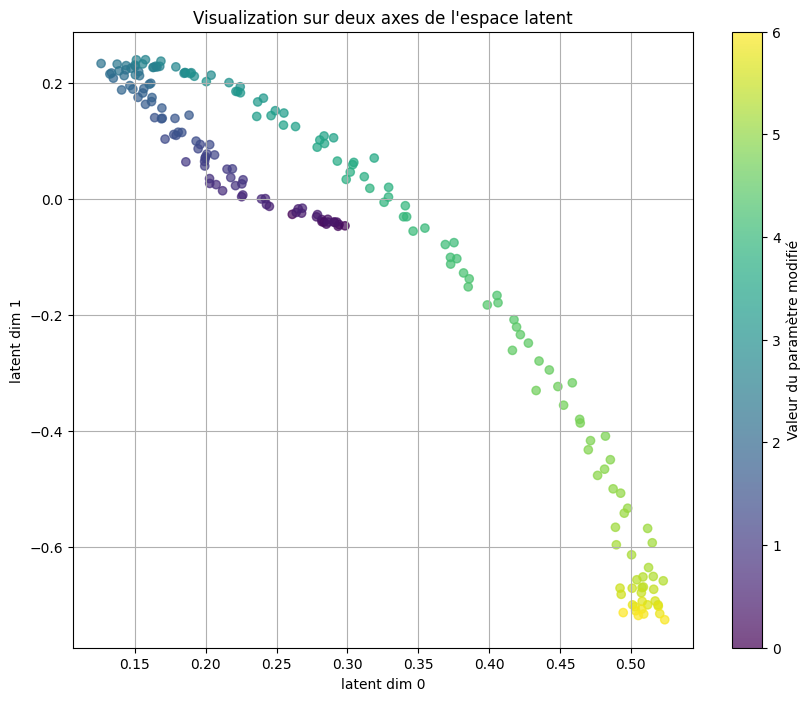

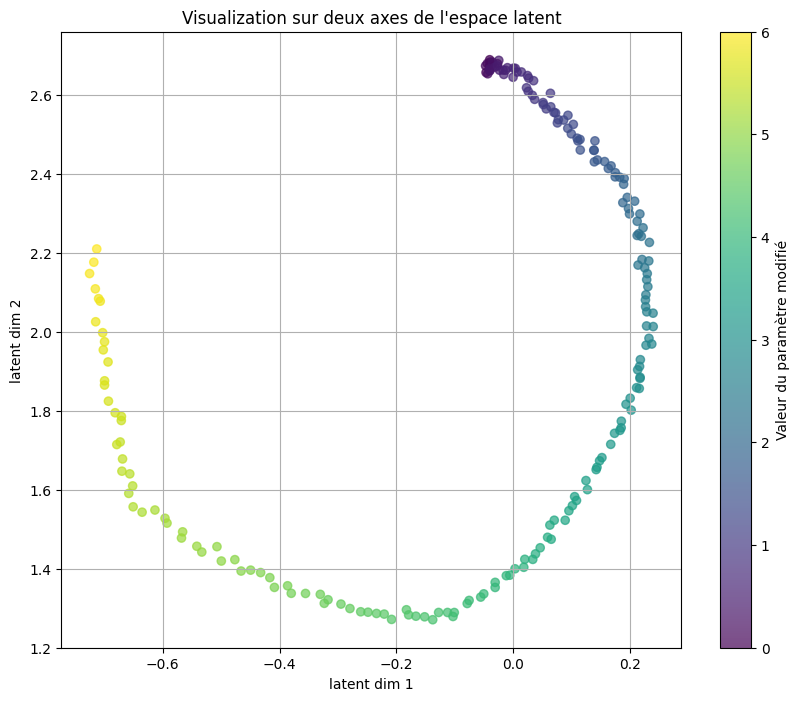

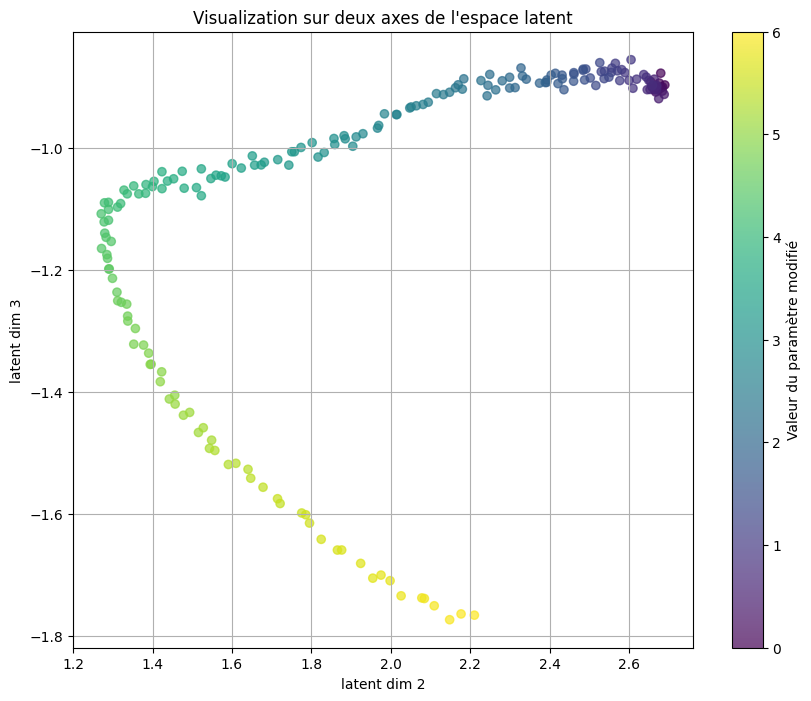

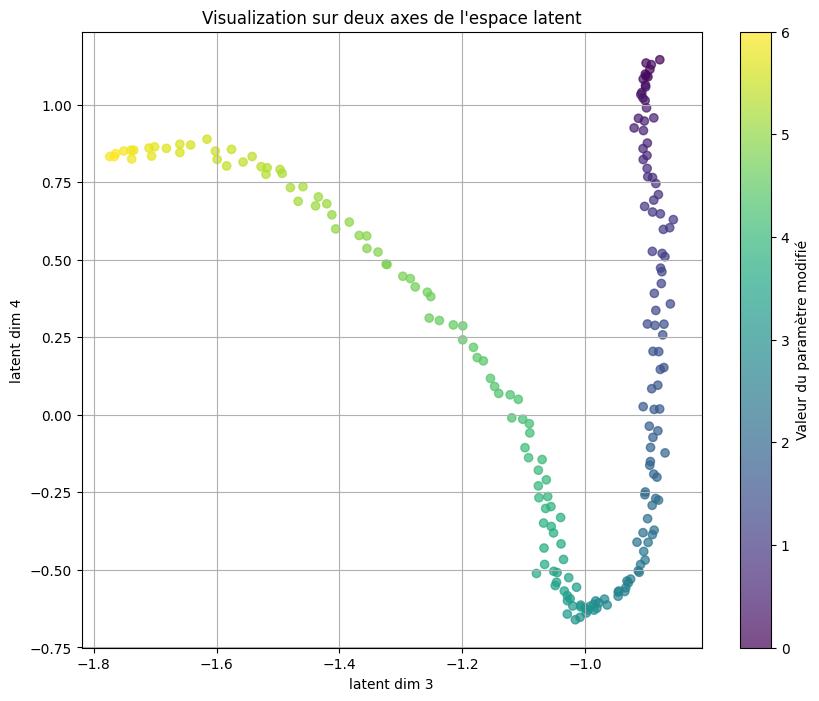

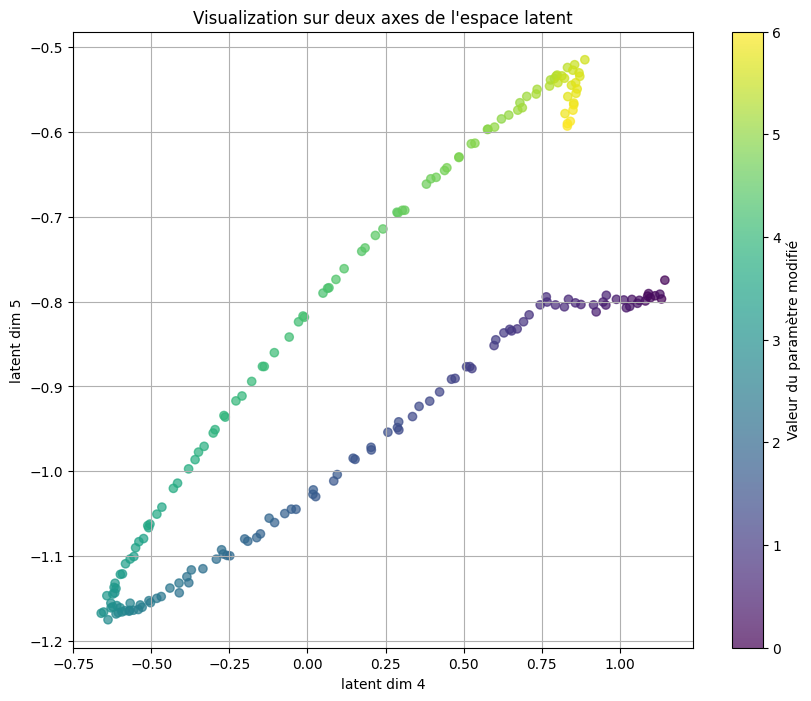

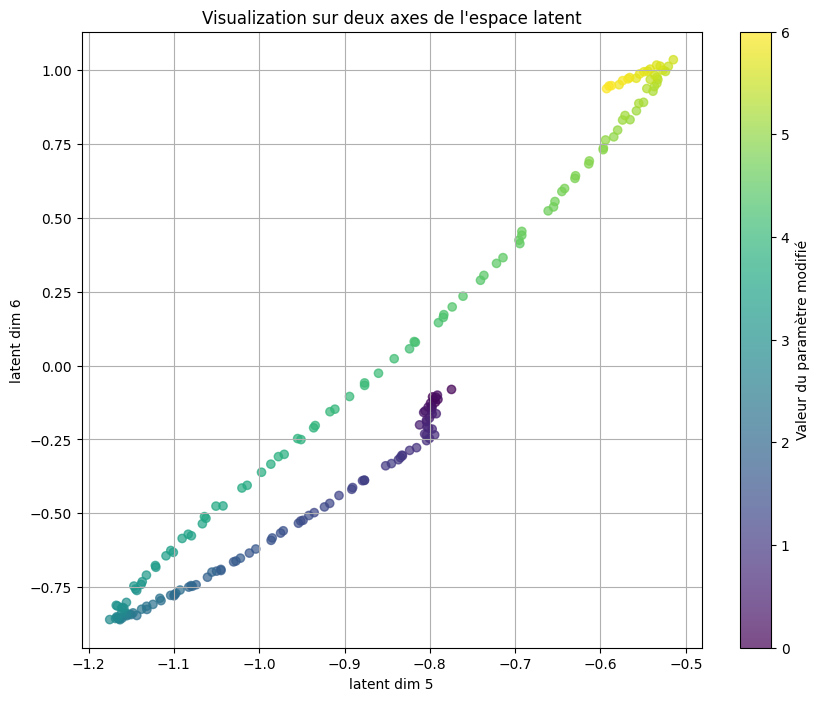

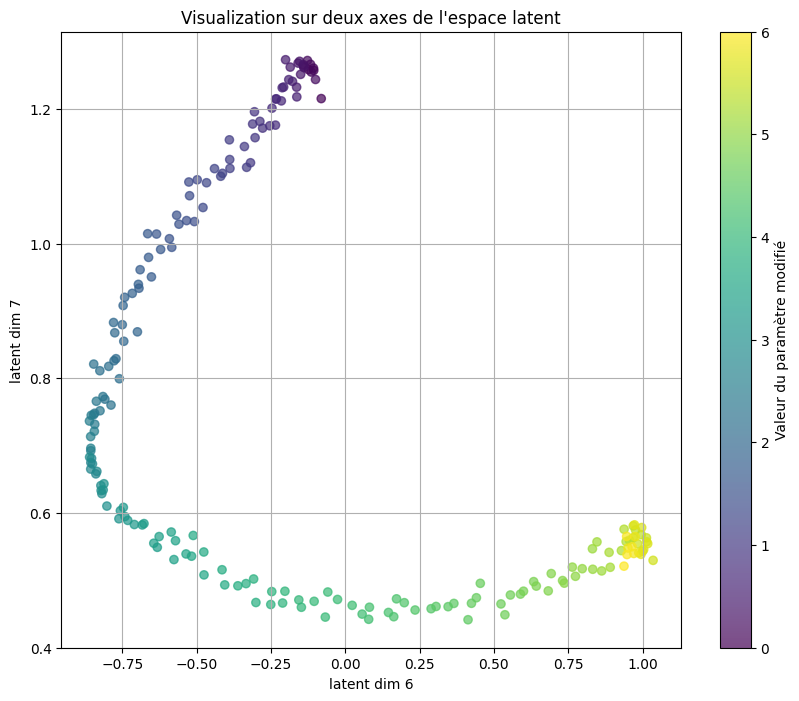

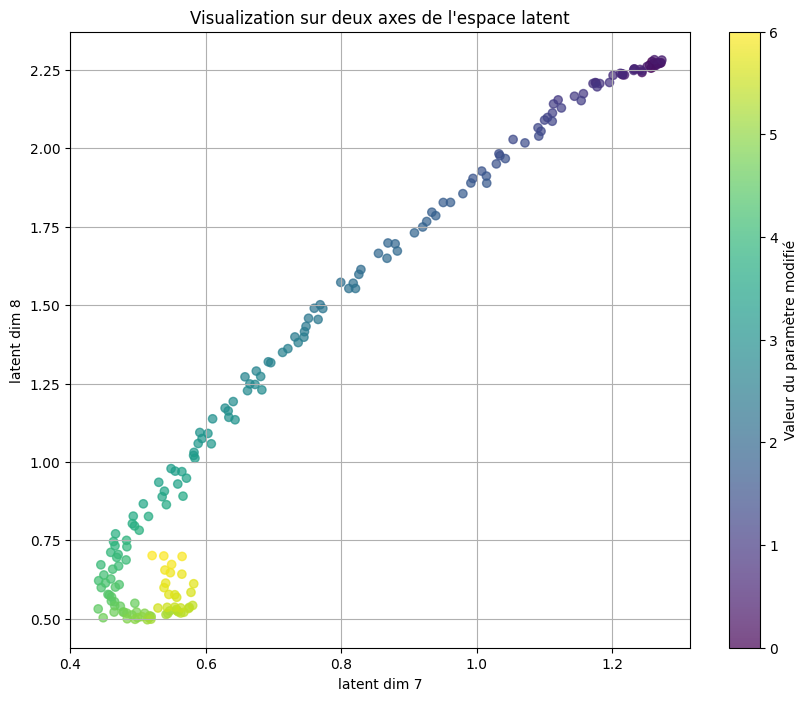

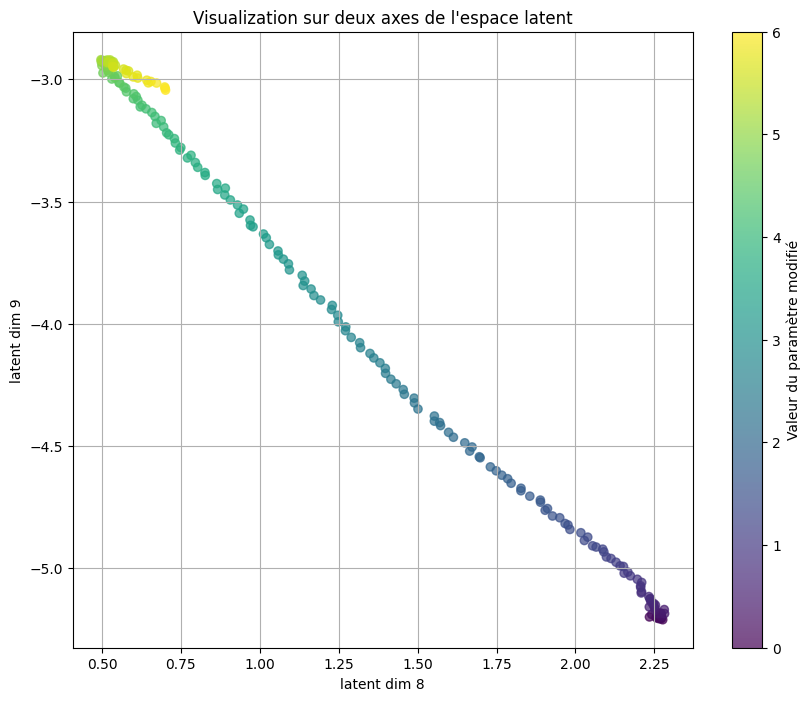

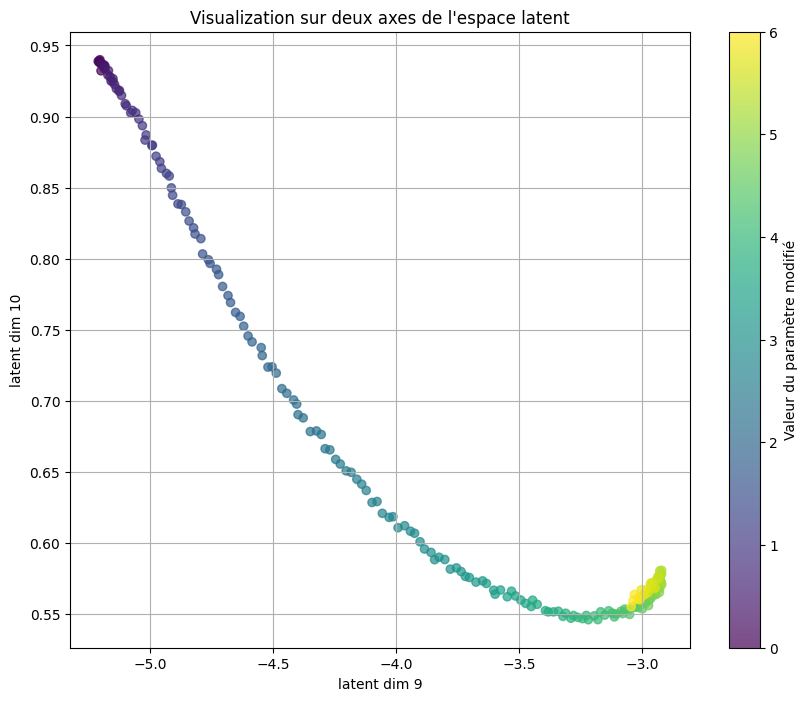

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

# Fonction pour générer une suite de signaux avec un paramètre qui augmente progressivement
def generate_signal_sequence(generator, param_name,index_param,  initial_params, start, stop, num_steps, **kwargs):
    """
    Génère une séquence de signaux en faisant varier un seul paramètre.

    Args:
        generator (object): Objet contenant la méthode generate_signal.
        param_name (str): Nom du paramètre à faire varier ("a", "b", "w", "phi").
        initial_params (dict): Dictionnaire des paramètres initiaux.
        start (float): Valeur initiale du paramètre à faire varier.
        stop (float): Valeur finale du paramètre à faire varier.
        num_steps (int): Nombre d'étapes entre start et stop.
        **kwargs: Arguments supplémentaires pour la méthode generate_signal.

    Returns:
        list: Liste des signaux générés.
        list: Liste des valeurs du paramètre modifié.
    """
    signals = []
    modified_values = np.linspace(start, stop, num_steps)

    for value in modified_values:
        params = initial_params.copy()
        params[param_name] = [value if i == index_param else v for i, v in enumerate(params[param_name])]
        signal = generator.generate_signal(
            a=params["a"], b=params["b"], w=params["w"], phi=params["phi"], **kwargs
        )
        signals.append(signal)

    return signals, modified_values

# Initialisation des paramètres initiaux
initial_params = {
    "a": [1, 0.5, -0.1, 0.05],
    "b": [2, 1.5, 1],
    "w": [2, 1.5, 1.1],
    "phi": [0, 0, 0],
}

# Générer un dataset complet pour t-SNE
signals, modified_values = generate_signal_sequence(
    generator=generator,
    param_name="w",
    index_param=0,
    initial_params=initial_params,
    start=0,
    stop=6,
    num_steps=200,
    num_samples=10000,
    time_range=(-1, 1),
    noise_std=0.2
)

# Obtenir les représentations latentes des signaux
latent_vectors = []
for signal in signals:
    signal_tensor = torch.tensor(signal, dtype=torch.float32).unsqueeze(0)
    with torch.no_grad():
        _, latent = autoencoder(signal_tensor)  
    latent_vectors.append(latent.squeeze().numpy())

latent_vectors = np.array(latent_vectors)


# Visualisation dans l'espace latent
for i in range (10) :
    plt.figure(figsize=(10, 8))
    sc = plt.scatter(latent_vectors[:, i], latent_vectors[:, i+1], c=modified_values, cmap="viridis", alpha=0.7, label="Signals")
    plt.title("Visualization sur deux axes de l'espace latent")
    plt.xlabel(f"latent dim {i}")
    plt.ylabel(f"latent dim {i+1}")
    plt.colorbar(sc, label="Valeur du paramètre modifié")
    plt.grid(True)
    plt.show()





